# Ejercicio 3. Árboles, Random Forest, Boosting y Bagging

In [1]:
import pandas                  as     pd
from   sklearn                 import tree
import numpy                   as     np
from   sklearn.metrics         import accuracy_score
from   sklearn.model_selection import train_test_split,cross_val_score
from   sklearn.ensemble        import BaggingClassifier,RandomForestClassifier
from   sklearn.ensemble        import AdaBoostClassifier,GradientBoostingClassifier
import matplotlib.pylab        as     plt 
from   sklearn.model_selection import GridSearchCV
import sklearn

Iniciamos cargando los datos:

In [2]:
data=pd.read_csv('sonar.csv',sep=',',header=0)
data.shape
data.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V52,V53,V54,V55,V56,V57,V58,V59,V60,Y
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.018,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.014,0.0049,0.0052,0.0044,R


Verifiquemos que las etiquetas de los datos sean correctas o si hay que eliminar renglones:

In [3]:
print(np.unique(data["Y"]))

['M' 'R']


In [4]:
print("Número de datos de rebote en metal: ", len(data[data["Y"]=='M']))
print("Número de datos de rebote en rocas: ", len(data[data["Y"]=='R']))

Número de datos de rebote en metal:  111
Número de datos de rebote en rocas:  97


Hacemos un split en datos de entrenamiento y validación en una proporción de 70-30

In [5]:
Y = data.pop("Y")
X = data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

### Inciso a). Ajuste un modelo de árbol de clasificación para predecir la variable de respuesta, si es una roca o una mina.

Entonces, primero ajustamos un árbol solo con el método, tree.DecisionTreeClassifier, sin restringir 
la profundidad máxima o el número máximo de hojas. La optimización con las restricciones a estos parámetros +
las realizamos después. 

In [6]:
tr=tree.DecisionTreeClassifier(criterion="gini")
trf=tr.fit(X_train,y_train)

In [7]:
ypred=trf.predict(X_test)
print("Porcentaje de datos bien clasificados: ", accuracy_score(y_test,ypred))

Porcentaje de datos bien clasificados:  0.6984126984126984


Permitiendo que el número máximo de nodos y de hojas crezca de forma indefinida llegamos solamente a un 69.8% de accuracy, por lo que sí conviene realizar la optimización de hiperparámetros del siguiente inciso.

In [8]:
print("Profundidad máxima del árbol: ", tr.tree_.max_depth)
print("Número de hojas del árbol: ", tr.tree_.n_leaves)
print("Número de nodos del árbol: ", tr.tree_.node_count)

Profundidad máxima del árbol:  5
Número de hojas del árbol:  13
Número de nodos del árbol:  25


### Inciso b) Haga optimización de hiperparametros, variando los la profundidad del árbol, el máximo número de nodos hojas y el criterio de impureza.

Definimos las profundidades máximas que permitiremos en la búsqueda. Como sin restricciones llegamos a 7, vamos a considerar un de [4, 11]

In [9]:
depths_to_search = [i for i in range(4,12)]

El rango para el número de hojas máximo lo tomaremos desde [5,40], para permitir un rango de búsqueda en donde pueda crecer un  poco más debido a las otras restricciones. 

In [10]:
max_leafs_to_search = [i for i in range(5, 41)]

Definidos los parámetros de la búsqueda para la optimización de los hiperparámetros, ejecutamos la búsqueda:

In [11]:
depths_to_search

param_grid = {
    'max_depth' : depths_to_search,
    'max_leaf_nodes' : max_leafs_to_search,
    'criterion':["gini", "entropy"] # gini o entropy son las únicas opciones del método en sklearn 
}
model = GridSearchCV(tree.DecisionTreeClassifier(),param_grid, scoring = 'accuracy')
model.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11],
                         'max_leaf_nodes': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                            15, 16, 17, 18, 19, 20, 21, 22, 23,
                                            24, 25, 26, 27, 28, 29, 30, 31, 32,
                                            33, 34, ...]},
             scoring='accuracy')

Analizamos los resultados obtenidos con esta optimización:

In [12]:
print("model score: %.3f" % model.score(X_test, y_test))
print ("hiperparametros: ",str(model.best_params_))

model score: 0.778
hiperparametros:  {'criterion': 'gini', 'max_depth': 6, 'max_leaf_nodes': 22}


Observamos que la precisión aumenta en aproximadamente 8%, que es bastante bueno. Pasó del 69.8% al 77.8%

In [13]:
# Nos quedamos con el mejor estimador en lugar del árbol inicial que teníamos.
tr = model.best_estimator_

### c) Haga un análisis costo complejidad y gráfique ccp alpha vs impureza, numero de nodos hoja, y finalmente la gráfica de alpha vs accuracy en la muestra de entrenamiento y de prueba. ¿Qué concluye acerca del valor de ccp alpha?

Iniciamos ejecutando el análisis de costo complejidad:

In [36]:
path = tr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#### Gráfica de ccp-$\alpha$ vs impureza:

Text(0.5, 1.0, 'Acercamiento CCP Alfa vs Impureza, menos el último dato')

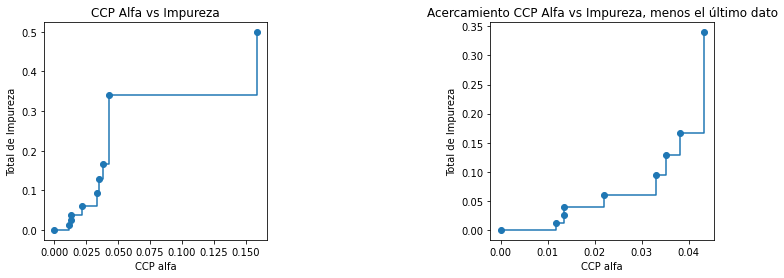

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.subplots_adjust(wspace=1)

ax1.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
ax1.set_xlabel("CCP alfa")
ax1.set_ylabel("Total de Impureza")
ax1.set_title("CCP Alfa vs Impureza")

ax2.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax2.set_xlabel("CCP alfa")
ax2.set_ylabel("Total de Impureza")
ax2.set_title("Acercamiento CCP Alfa vs Impureza, menos el último dato")

Text(0.5, 1.0, 'Acercamiento CCP Alfa vs Impureza, menos el último dato')

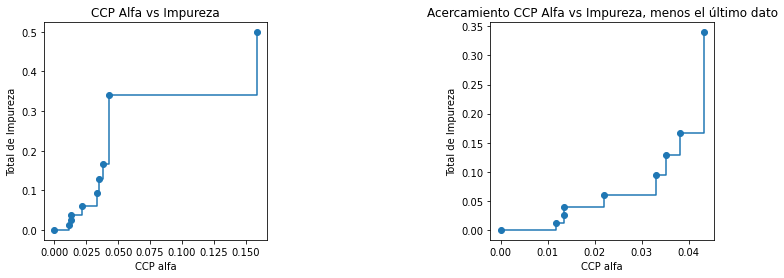

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.subplots_adjust(wspace=1)

ax1.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
ax1.set_xlabel("CCP alfa")
ax1.set_ylabel("Total de Impureza")
ax1.set_title("CCP Alfa vs Impureza")

ax2.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax2.set_xlabel("CCP alfa")
ax2.set_ylabel("Total de Impureza")
ax2.set_title("Acercamiento CCP Alfa vs Impureza, menos el último dato")

Para los análisis siguientes, obtenemos los árboles en cada paso intermedio:

In [39]:
models = []
for ccp_alpha in ccp_alphas:
    mod = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    mod.fit(X_train, y_train)
    models.append(mod)

#### Gráfica de ccp-$\alpha$ vs número de nodos hoja:

Text(0.5, 1.0, 'CCP Alfa vs Nodos Hoja, menos el último dato')

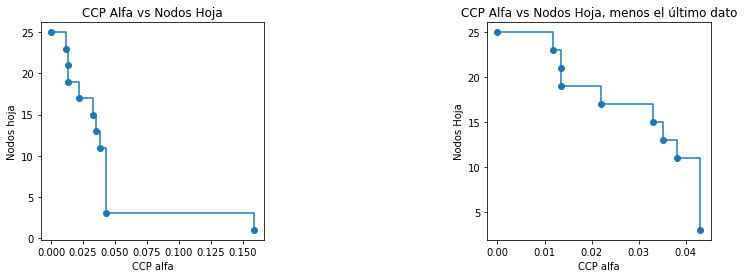

In [40]:
node_counts = [mod.tree_.node_count for mod in models]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.subplots_adjust(wspace=1)

ax1.plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax1.set_xlabel("CCP alfa")
ax1.set_ylabel("Nodos hoja")
ax1.set_title("CCP Alfa vs Nodos Hoja")

ax2.plot(ccp_alphas[:-1], node_counts[:-1], marker='o', drawstyle="steps-post")
ax2.set_xlabel("CCP alfa")
ax2.set_ylabel("Nodos Hoja")
ax2.set_title("CCP Alfa vs Nodos Hoja, menos el último dato")

#### Gráfica de ccp-$\alpha$ vs profundidades:

Text(0.5, 1.0, 'CCP Alfa vs Profundidad, menos el último dato')

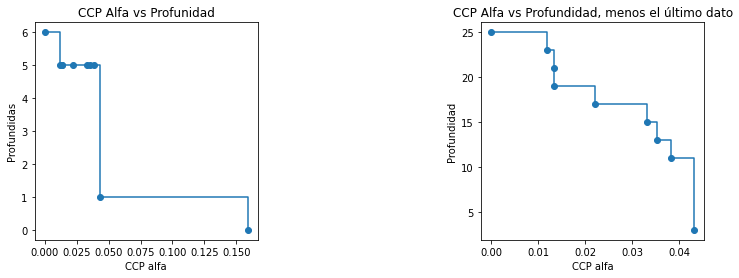

In [41]:
depths = [mod.tree_.max_depth for mod in models]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.subplots_adjust(wspace=1)

ax1.plot(ccp_alphas, depths, marker='o', drawstyle="steps-post")
ax1.set_xlabel("CCP alfa")
ax1.set_ylabel("Profundidas")
ax1.set_title("CCP Alfa vs Profunidad")

ax2.plot(ccp_alphas[:-1], node_counts[:-1], marker='o', drawstyle="steps-post")
ax2.set_xlabel("CCP alfa")
ax2.set_ylabel("Profundidad")
ax2.set_title("CCP Alfa vs Profundidad, menos el último dato")

#### Gráfica de ccp-$\alpha$ vs el accuracy de entrenamiento y de validación:

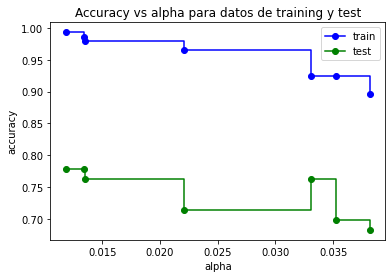

In [42]:
train_scores = [mod.score(X_train, y_train) for mod in models[:-1]]
test_scores = [mod.score(X_test, y_test) for mod in models[:-1]]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha para datos de training y test")
ax.plot(ccp_alphas[1:8], train_scores[1:8], marker='o', color='b', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas[1:8], test_scores[1:8], marker='o', color='g', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [43]:
print(ccp_alphas)

[0.         0.01182266 0.01343943 0.01347962 0.02206897 0.03310345
 0.0352126  0.03819629 0.0431675  0.15884169]


**Para concluir el análisis del valor de alpha:**

Aunque podemos ver que el modelo sigue sobreajustado (lo cual quiere decir que probablemente la poda es insuficiente para mitigarlo en este caso), pues vemos que aún sigue habiendo una diferencia de alrededor de 10% entre el accuracy de los datos de entrenamiento y los de validación; el valor óptimo de alpha en este caso sería **0.331** ya que es el punto donde la distancia entre ambas medidas se minimiza.

### d) Ajuste un modelo de Random Forest, Bagging y Boosting a los datos de sonar.

En este caso no se nos pide una optimización de hiperparámetros, por lo cual haremos el ajuste a cada uno de estos modelos usando ya sea los hiperparámetros por defecto en los métodos de python, o valores elegidos arbitrariamente dentro de un rango razonable.

**Iniciamos ajustando un modelo de RandomForest**

Elegimos como profundidad máxima de los árboles del bosque 7, pues el árbol que resultó de optimizar los hiperparámetros tiene profundidad de 6.

Esto da la oportunidad a tener árboles bien ajustados, pero también con buena variabilidad.

In [44]:
randomForest = RandomForestClassifier(max_depth=7,n_estimators=100, random_state=42)
randomForest.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=42)

Calculamos el accuracy sobre los datos de validación para ver qué también ajustó el modelo.

In [46]:
y_forest=randomForest.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test,y_forest))

Test Accuracy:  0.873015873015873


Tenemos una precisión de 87%, lo cual supera bastante a la obtenida con el modelo de árbol simple (77.8%).

**Ajustamos ahora un modelo de Bagging**

Elegimos como número de clasificadores 80. La máxima profundidad posible del árbol la dejamos en 7 como la vez pasada.

In [61]:
cart=tree.DecisionTreeClassifier(max_depth=7)
n_trees=80
baggingModel=BaggingClassifier(base_estimator=cart,n_estimators=n_trees,random_state=42*2)
baggingModel.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),
                  n_estimators=80, random_state=84)

Calculamos el accuracy sobre los datos de validación para ver qué también ajustó el modelo.

In [62]:
y_bag=baggingModel.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test,y_bag))

Test Accuracy:  0.8412698412698413


Vemos que este modelo, sin optimización de hiperparámetros, lo sigue haciendo mejor que el modelo de árbol, aunque ligeramente peor que el bosque aleatorio.

**Finalmente, ajustemos un modelo de Boosting. Elegimos GradientBoosting en este caso**

Elegimos dejar los hiperparámetros como el learning_rate en su valor por defecto. Dejamos el número de estimadores en 100. Para reproducibilidad, fijamos la semilla del valor aleatorio como en los casos anteriores; esta vez con un valor de 42*3

In [82]:
boostingModel = GradientBoostingClassifier(n_estimators=100,random_state=42*3)
boostingModel.fit(X_train,y_train)

GradientBoostingClassifier(random_state=126)

In [83]:
y_boost = boostingModel.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test,y_boost))

Test Accuracy:  0.8571428571428571


De nuevo, sin optimizar hiperparámetros ya es mucho mejor que el árbol simple; ligeramente mejor que el bagging; pero ligeramente peor que el random forest.

### e) Obtenga las matrices de confusión y curva ROC

En la redacción queda algo ambiguo, pero vamos a hacerlo para el árbol optimizado y cada uno de los modelos que acabamos de ajustar. 

#### Iniciamos con las matrices de confusión: 

In [87]:
from sklearn.metrics import plot_confusion_matrix

**Matriz de confusión del árbol**

array([[0.88888889, 0.30555556],
       [0.11111111, 0.69444444]])

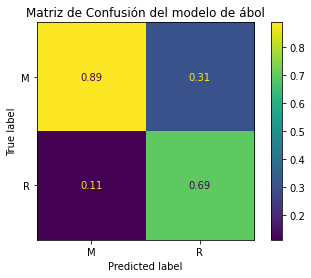

In [89]:
disp = plot_confusion_matrix(tr, X_test, y_test, normalize="pred")
disp.ax_.set_title("Matriz de Confusión del modelo de ábol")
disp.confusion_matrix

**Matriz de confusión del RandomForest**

array([[0.90909091, 0.16666667],
       [0.09090909, 0.83333333]])

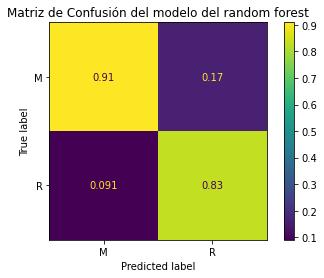

In [90]:
disp = plot_confusion_matrix(randomForest, X_test, y_test, normalize="pred")
disp.ax_.set_title("Matriz de Confusión del modelo del random forest")
disp.confusion_matrix

**Matriz de confusión del bagging**

array([[0.85714286, 0.17857143],
       [0.14285714, 0.82142857]])

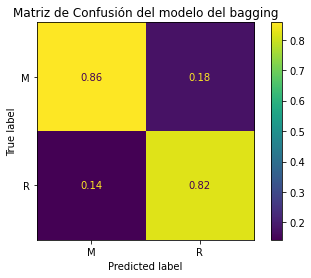

In [91]:
disp = plot_confusion_matrix(baggingModel, X_test, y_test, normalize="pred")
disp.ax_.set_title("Matriz de Confusión del modelo del bagging")
disp.confusion_matrix

**Matriz de confusión del Boosting**

array([[0.88235294, 0.17241379],
       [0.11764706, 0.82758621]])

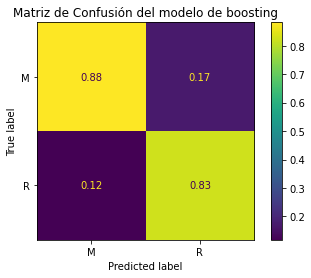

In [92]:
disp = plot_confusion_matrix(boostingModel, X_test, y_test, normalize="pred")
disp.ax_.set_title("Matriz de Confusión del modelo de boosting")
disp.confusion_matrix

Al analizar las matrices de confusión nos podemos dar cuenta de un par de cosas:
* Nuestro árbol es malo clasificando las rocas, pues clasifica muchas instancias de metal como roca.
* Los demás clasificadores mejoran mucho en este rubro, pero se mantiene como el punto donde más fallan (si pensáramos Metal como Verdadero y Roca como falso, los modelos tienen la falla más grande en falsos negativos).
* Aunque no es por mucho, ya que tanto las rocas clasificadas como metal y viceversa se mantienen alrededor del 15%, con excepción del RandomForest, que logró ser el mejor clasificador reduciendo el número de rocas clasificadas como metal a menos del 10%.

#### Finalmente, graficamos las curvas ROC.

In [117]:
def transform_metal_roca(y_pred):
    tr = []
    for y in y_pred:
        if y=='M':
            tr.append(1)
        elif y=='R':
            tr.append(0)
    return tr

In [118]:
para_titulos = ["del modelo de árbol", "del modelo de RandomForest",
                "del modelo de Bagging", "del modelo de Boosting"]

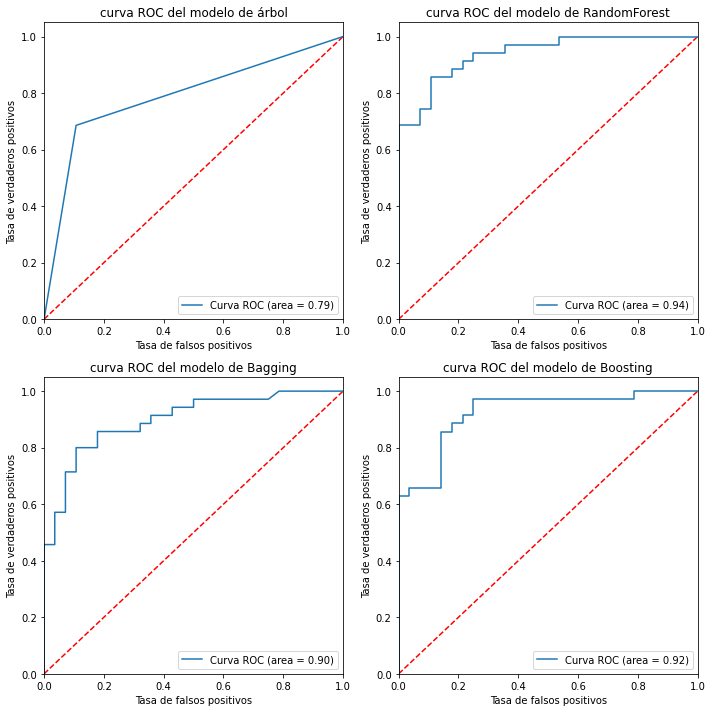

In [137]:
y_tr = tr.predict(X_test)
all_m = [tr, randomForest, baggingModel, boostingModel]

fig = plt.figure(figsize=(10,10))
aucs = []

for m,num in zip(all_m, range(0,4)):
    # Obtenemos las probabilidades. En el caso del árbol 
    # la gráfica no será muy buena pues se obtendrá sólo 0 o 1.
    y_pred = m.predict_proba(X_test)
    y_t = transform_metal_roca(y_test)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(y_t, y_pred[:,0])
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    # Añadimos el subplot
    ax = fig.add_subplot(2,2,num+1)
    # Graficamos la identidad
    ax.plot([0, 1], [0, 1],'r--')
    # Límites de los ejes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.plot(fpr, tpr, label=f'Curva ROC (area = %0.2f)' % roc_auc)
    
    ax.set_xlabel('Tasa de falsos positivos')
    ax.set_ylabel('Tasa de verdaderos positivos')
    ax.set_title(f"curva ROC {para_titulos[num]}")
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [143]:
# Imprimimos el área bajo la curva:
for i in range(0,4):
    print("AUC de la curva ROC de   ", para_titulos[i], ": \t", aucs[i])

AUC de la curva ROC de    del modelo de árbol : 	 0.7892857142857144
AUC de la curva ROC de    del modelo de RandomForest : 	 0.939795918367347
AUC de la curva ROC de    del modelo de Bagging : 	 0.8984693877551021
AUC de la curva ROC de    del modelo de Boosting : 	 0.9224489795918368
